### 导入库

In [1]:
%matplotlib inline
import os
import glob
import xgboost
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,Lasso,LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV,KFold, cross_val_predict,StratifiedKFold,train_test_split,cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,plot_confusion_matrix,auc,plot_roc_curve,ConfusionMatrixDisplay,mean_squared_error,roc_auc_score
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.decomposition import PCA

In [2]:
# 导入特征
df = pd.read_excel(r"F:\Desktop\Kidney\51例\vp.xlsx")
features_names=list(df.columns)[2:102]
target=df[list(df.columns)[1:2]]
features=df[list(df.columns)[2:102]]

scaler = StandardScaler()
features_scaler = pd.DataFrame(scaler.fit_transform(features))

In [33]:
X_data = features_corr
y_data = target

def Train_model(clf, X, y, name):
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
    acc = []
    auc = []
    pre = []
    f1 = []
    sen = []
    spe = []
    #fnr = []
    #fpr = []
    
    for train_index, test_index in cv.split(X, y): 
        X_train = X.iloc[train_index] 
        y_train = y.iloc[train_index] 
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        scaler = StandardScaler()
        #scaler = MinMaxScaler()
        #scaler = RobustScaler()
        X_train_scaler = pd.DataFrame(scaler.fit_transform(X_train))
        X_test_scaler = pd.DataFrame(scaler.fit_transform(X_test))
        
        sm = SMOTE(sampling_strategy='auto', random_state=1234)
        X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)

        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X_test_scaler)
        
        acc.append(accuracy_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred)) 
        pre.append(precision_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        #fnr.append(fn/tp+fn)
        #fpr.append(fp/fp+tn)
    
    result_dict = {'Accuracy': [np.mean(acc)], 
                   'Auc': [np.mean(auc)], 
                   'Sensitivity(TPR)': [np.mean(sen)], 
                   'Specificity(TNR)': [np.mean(spe)],
                   #'FNR': [np.mean(fnr)],
                   #'FPR': [np.mean(fpr)],
                   'Precision': [np.mean(pre)],
                   'F1-score': [np.mean(f1)]
                   }
    
    result = pd.DataFrame(result_dict, index=[name])
    return result

#创建分类器
lr_clf = LogisticRegression(C=100, penalty = 'l1', solver= 'liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=2, p=1, weights='uniform')
svm_clf = SVC(kernel='rbf',C=1, gamma=0.1, probability=True)
forest_clf = RandomForestClassifier(random_state=0,n_jobs=-1,class_weight="balanced")
gra_clf = GradientBoostingClassifier(n_estimators=500)
ada_clf = AdaBoostClassifier(n_estimators=500)
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=19, min_samples_leaf= 1, min_samples_split= 8, splitter= 'random',random_state=1234)
lgbm_clf = LGBMClassifier(n_estimators=500)
xgb_clf = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.2, 
                                gamma=0.5, max_depth=20, verbosity=0)
en_clf = VotingClassifier(estimators=[('rf', forest_clf),('ada', ada_clf), ('gb', gra_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf)],
                         voting='soft',weights=[5, 5, 2, 5, 5])


#训练分类器并输出结果
result3 = Train_model(lr_clf, X_data, y_data, 'Logistic Regression')
result3 = pd.concat([result3, Train_model(knn_clf, X_data, y_data, 'KNN')])
result3 = pd.concat([result3, Train_model(svm_clf, X_data, y_data, 'SVM')])
result3 = pd.concat([result3, Train_model(dt_clf, X_data, y_data, 'Decision Tree')])
result3 = pd.concat([result3, Train_model(forest_clf, X_data, y_data, 'Random Forest')])
result3 = pd.concat([result3, Train_model(ada_clf, X_data, y_data, 'AdaBoosting')])
result3 = pd.concat([result3, Train_model(gra_clf, X_data, y_data, 'Gradient Boosting')])
result3 = pd.concat([result3, Train_model(lgbm_clf,X_data, y_data, 'LGBM')])
result3 = pd.concat([result3, Train_model(xgb_clf, X_data, y_data, 'XGBoost')])
result3 = pd.concat([result3, Train_model(en_clf,X_data, y_data, 'Ensemble')])
result3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib

,Accuracy,Auc,F1-score,Precision,Sensitivity(TPR),Specificity(TNR)
Logistic Regression,0.646667,0.654500,0.421009,0.309120,0.666667,0.642333
KNN,0.764086,0.626167,0.393065,0.432381,0.400000,0.852333
SVM,0.764086,0.601167,0.367677,0.437778,0.333333,0.869000
Decision Tree,0.712688,0.569167,0.294048,0.268333,0.333333,0.805000
Random Forest,0.790968,0.567500,0.258586,0.373333,0.200000,0.935000
AdaBoosting,0.673548,0.558167,0.248792,0.230112,0.366667,0.749667
Gradient Boosting,0.764731,0.614333,0.390476,0.433333,0.366667,0.862000
LGBM,0.803871,0.651333,0.416616,0.513333,0.400000,0.902667
XGBoost,0.751613,0.555833,0.256364,0.356667,0.233333,0.878333
Ensemble,0.804086,0.613500,0.354603,0.508333,0.300000,0.927000


Computing regularization path using the coordinate descent lasso...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025985702789186327, tolerance: 0.0004375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013161503052325774, tolerance: 0.0004375
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000541258

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00824182345487734, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030635426389479248, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002891708621539202, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001742251901272418, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015549222415094377, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006535464762165155, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number o

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012207447913047613, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01138420631417942, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009026891071346195, tolerance: 0.0006439024390243903
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02373154338278488, tolerance: 0.0007024390243902441
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02404433096550007, tolerance: 0.0007024390243902441
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01786818630364828, tolerance: 0.0007024390243902441
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026027306343505696, tolerance: 0.0007560975609756099
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002762975801250178, tolerance: 0.0007560975609756099
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003352250121440692, tolerance: 0.0007560975609756099
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of

0.120294605257


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.041435231687103315, tolerance: 0.0007560975609756099
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04001069962432069, tolerance: 0.0007560975609756099
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038281935885456024, tolerance: 0.0007560975609756099
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

(0.00016066996562253395,
 0.16486107416793516,
 -0.036617881307362612,
 2.0921163124251403)

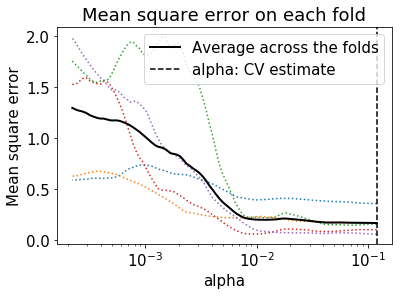

In [27]:
import time
EPSILON = 1e-4
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=5).fit(X_scaler, y_scaler)
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
#设置字体大小
matplotlib.rcParams.update({'font.size': 15})
ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ":")
plt.plot(
    model.alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate"
)
print(model.alpha_+ EPSILON)
plt.legend()

plt.xlabel('alpha')
plt.ylabel("Mean square error")
plt.title(
    "Mean square error on each fold"
    
)
plt.axis("tight")
#plt.ylim(ymin, ymax)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08501356399584528, tolerance: 0.000803921568627451
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08665704326198462, tolerance: 0.000803921568627451
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0884830428443991, tolerance: 0.000803921568627451
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08349394435804025, tolerance: 0.000803921568627451
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045997060354620256, tolerance: 0.000803921568627451
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05071628091658864, tolerance: 0.000803921568627451
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

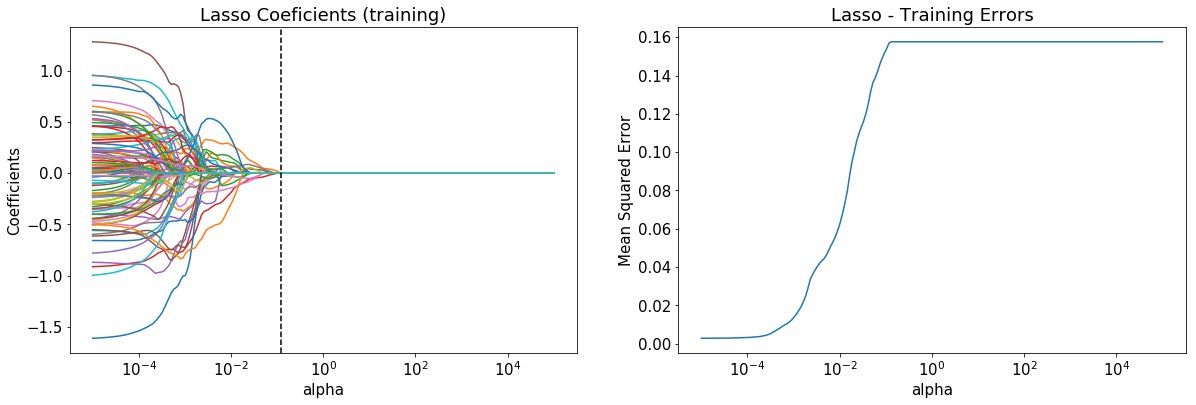

In [26]:
model_lasso = Lasso()
coeficents = []
errors_train = []
#errors_test = []

alphas = np.logspace(-5, 5, 200)
for a in alphas:
    model_lasso.set_params(alpha=a)
    model_lasso.fit(X_scaler, y_scaler)
    coeficents.append(model_lasso.coef_)
    errors_train.append(mean_squared_error(y_scaler,model_lasso.predict(X_scaler)))
#    errors_test.append(mean_squared_error(diabetes_y_test,model_lasso.predict(diabetes_X_test)))

plt.figure(figsize=(20, 6))
matplotlib.rcParams.update({'font.size': 15})
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coeficents)
ax.set_xscale('log')
plt.axvline( model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate")
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coeficients (training)')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, errors_train,linestyle="-", label="Train")
#ax.plot(alphas, errors_test,linestyle="--", label="Test")
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error')
plt.title('Lasso - Training Errors')
plt.axis('tight')

plt.show()

In [31]:
#逻辑回归分类器调参
lr = LogisticRegression()
parameters = {
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000,2000],
    'penalty':['l2','l1'],
    'solver':["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}
grid_search_lr = GridSearchCV(lr, parameters, cv = 5, n_jobs = -1)
grid_search_lr.fit(X_resam, y_resam)
print("The best params are:",grid_search_lr.best_params_)
print("The best accuracy is:", grid_search_lr.best_score_)

The best params are: {'C': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
The best accuracy is: 0.857469387755


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [ 0.50391837  0.50391837  0.51632653  0.50391837  0.50791837         nan
         nan  0.5                nan  0.50816327  0.59330612  0.59330612
  0.60563265  0.59330612  0.59330612         nan         nan  0.5
         nan  0.49591837  0.71126531  0.71126531  0.71110204  0.71126531
  0.70718367         nan         nan  0.64220408         nan  0.63787755
  0.79657143  0.79657143  0.7924898   0.76391837  0.7477551          nan
         nan  0.768              nan  0.72334694  0.83306122  0.82897959
  0.82897959  0.78432653  0.7355102          nan         nan  0.84530612
         nan  0.74359184  0.85346939  0.85346939  0.84938776  0.78432653
  0.7355102          nan         nan  0.85338776         nan  0.7355102
  0.85746939  0.85746939  0.85746939  0.78432653  0.7355102          nan
         nan  0.85738776         nan  0.7355102   0.85746939  

In [33]:
#knn分类器调参
knn = KNeighborsClassifier()
parameters = {
    'n_neighbors':[1,2,3,4,5,8],
    'weights':["uniform",  "distance"],
    'p':[1,2,3,4]
}
grid_search_knn = GridSearchCV(knn, parameters, cv = 5, n_jobs = -1)
grid_search_knn.fit(X_resam, y_resam)
print("The best params are:",grid_search_knn.best_params_)
print("The best accuracy is:", grid_search_knn.best_score_)

The best params are: {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
The best accuracy is: 0.890530612245


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [28]:
#SVM分类器调参
svc = SVC()
parameters = {
    'kernel' : ['linear', 'rbf'],
    'gamma' : [0.0001, 0.001, 0.01, 0.1, 1],
    'C' : [0.01, 0.05, 0.5, 0.1, 1, 10, 15, 20]
}

grid_search = GridSearchCV(svc, parameters,cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_resam, y_resam)
print("The best params are:",grid_search.best_params_)
print("The best accuracy is:", grid_search.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
The best params are: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
The best accuracy is: 0.92293877551


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [35]:
#决策树分类器调参
dtc = DecisionTreeClassifier()
parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 32, 1),
    'min_samples_leaf' : range(1, 10, 1),
    'min_samples_split' : range(2, 10, 1),
    'splitter' : ['best', 'random']
}
grid_search_dt = GridSearchCV(dtc, parameters, cv = 5, n_jobs = -1, verbose = 1)
grid_search_dt.fit(X_resam, y_resam)
print("The best params are:",grid_search_dt.best_params_)
print("The best accuracy is:", grid_search_dt.best_score_)

Fitting 5 folds for each of 8640 candidates, totalling 43200 fits
The best params are: {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 9, 'splitter': 'random'}
The best accuracy is: 0.866040816327


In [36]:
#随机森林分类器调参
forest = RandomForestClassifier()
parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_features' : ["auto", "sqrt", "log2"],
    'max_depth': [19,20,21],
    'min_samples_leaf' : [1,2,3],
    'min_samples_split' : [4,5,6],
    'n_estimators': [300,500,700]
}
grid_search_forest = GridSearchCV(forest, parameters, cv = 5, n_jobs = -1,verbose = 1)
grid_search_forest.fit(X_resam, y_resam)
print("The best params are:",grid_search_forest.best_params_)
print("The best accuracy is:", grid_search_forest.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The best params are: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}
The best accuracy is: 0.910612244898


In [46]:
#导入特征
test = pd.read_excel(r"F:/Desktop/Kidney/51例/dp.xlsx")
target_test=test[list(test.columns)[1:2]]
features_test=test[list(test.columns)[2:102]]
#特征标准化
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()
X_scaler = scaler.fit_transform(features_test)
y_scaler = target_test
#训练机器学习模型
X_test=X_scaler
y_test=y_scaler

#五折交叉验证
def Kfold_model_confusion(model, X, y, name):
    cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1234)
    accuracy = cross_val_score(model,X, y, cv=cv,scoring="accuracy",n_jobs=-1)
    auc = cross_val_score(model,X, y, cv=cv,scoring="roc_auc",n_jobs=-1)
    recall = cross_val_score(model,X, y, cv=cv,scoring="recall",n_jobs=-1)
    precision = cross_val_score(model,X, y, cv=cv,scoring="precision",n_jobs=-1)
    f1 = cross_val_score(model,X, y, cv=cv,scoring="f1",n_jobs=-1)
    result_dict = {'Accuracy': [accuracy.mean()], 
                  'Auc': [auc.mean()], 
                  'Recall': [recall.mean()], 
                  'Precision': [precision.mean()],
                  'F1 score': [f1.mean()]}
    result = pd.DataFrame(result_dict, index=[name])
    return result

#创建分类器
lr_clf = LogisticRegression(C=1000, penalty = 'l2', solver= 'liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=2, p=1, weights='uniform')
svm_clf = SVC(kernel='rbf',C=1, gamma=0.1, probability=True)
forest_clf = RandomForestClassifier(random_state=0,n_jobs=-1,class_weight="balanced")
gra_clf = GradientBoostingClassifier(n_estimators=500)
ada_clf = AdaBoostClassifier(n_estimators=500)
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=19, min_samples_leaf= 1, min_samples_split= 8, splitter= 'random',random_state=1234)
lgbm_clf = LGBMClassifier(n_estimators=500)
xgb_clf = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.2, 
                                gamma=0.5, max_depth=20, verbosity=0)
en_clf = VotingClassifier(estimators=[('rf', forest_clf),('ada', ada_clf), ('gb', gra_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf)],
                         voting='soft',weights=[5, 5, 2, 5, 5])


#训练分类器并输出结果
result3 = Kfold_model_confusion(lr_clf, X_test, y_test, 'Logistic Regression')
result3 = pd.concat([result3, Kfold_model_confusion(knn_clf, X_test, y_test, 'KNN')])
result3 = pd.concat([result3, Kfold_model_confusion(svm_clf, X_test, y_test, 'SVM')])
result3 = pd.concat([result3, Kfold_model_confusion(dt_clf, X_test, y_test, 'Decision Tree')])
result3 = pd.concat([result3, Kfold_model_confusion(forest_clf, X_test, y_test, 'Random Forest')])
result3 = pd.concat([result3, Kfold_model_confusion(ada_clf, X_test, y_test, 'AdaBoosting')])
result3 = pd.concat([result3, Kfold_model_confusion(gra_clf, X_test, y_test, 'Gradient Boosting')])
result3 = pd.concat([result3, Kfold_model_confusion(lgbm_clf,X_test, y_test, 'LGBM')])
result3 = pd.concat([result3, Kfold_model_confusion(xgb_clf, X_test, y_test, 'XGBoost')])
result3 = pd.concat([result3, Kfold_model_confusion(en_clf,X_test, y_test, 'Ensemble')])
result3

,Accuracy,Auc,F1 score,Precision,Recall
Logistic Regression,0.643333,0.4250,0.116667,0.083333,0.2
KNN,0.803333,0.3775,0.000000,0.000000,0.0
SVM,0.803333,0.4750,0.000000,0.000000,0.0
Decision Tree,0.723333,0.6050,0.316667,0.233333,0.5
Random Forest,0.783333,0.3225,0.000000,0.000000,0.0
AdaBoosting,0.663333,0.3100,0.000000,0.000000,0.0
Gradient Boosting,0.690000,0.5725,0.000000,0.000000,0.0
LGBM,0.663333,0.3900,0.000000,0.000000,0.0
XGBoost,0.783333,0.4550,0.000000,0.000000,0.0
Ensemble,0.783333,0.3150,0.000000,0.000000,0.0
